In [12]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy.stats import f_oneway, kruskal
from scipy.stats import ttest_ind

In [2]:
df = pd.read_csv("/Users/vidhimittal/Desktop/Honors/all_progpedia_elaboration_scores.csv")

print(df.info())
print(df["label"].value_counts())
print(df["language"].value_counts())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6132 entries, 0 to 6131
Data columns (total 11 columns):
 #   Column                 Non-Null Count  Dtype  
---  ------                 --------------  -----  
 0   filename               6132 non-null   object 
 1   path                   6132 non-null   object 
 2   language               6132 non-null   object 
 3   elaboration_score      6132 non-null   float64
 4   comment_density        6132 non-null   float64
 5   num_methods            6132 non-null   int64  
 6   avg_identifier_length  6132 non-null   float64
 7   doc_comment_density    6132 non-null   float64
 8   blank_line_ratio       6132 non-null   float64
 9   problem_id             6132 non-null   int64  
 10  label                  6132 non-null   object 
dtypes: float64(5), int64(2), object(4)
memory usage: 527.1+ KB
None
Accepted         2264
Wrong Answer     1982
Runtime Error    1886
Name: label, dtype: int64
java      4362
python    1770
Name: language, dtype: int

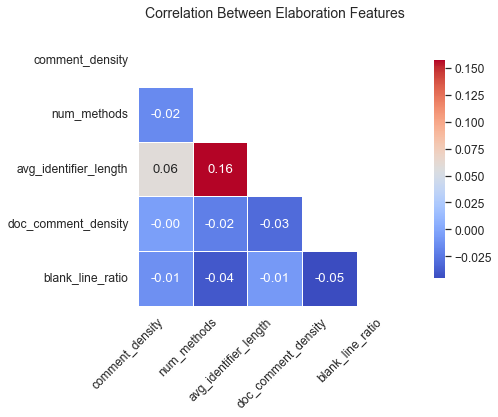

In [5]:
features = [
    'comment_density',
    'num_methods',
    'avg_identifier_length',
    'doc_comment_density',
    'blank_line_ratio'
]


corr_matrix = df[features].corr()

sns.set(style="white", font_scale=1.1)

mask = np.triu(np.ones_like(corr_matrix, dtype=bool))

plt.figure(figsize=(8, 6))
heatmap = sns.heatmap(
    corr_matrix, 
    mask=mask,
    annot=True, 
    cmap="coolwarm", 
    fmt=".2f", 
    linewidths=0.5, 
    square=True, 
    cbar_kws={"shrink": 0.8}
)

plt.title("Correlation Between Elaboration Features", fontsize=14, pad=15)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()


plt.show()

In [6]:
df.groupby('label')['elaboration_score'].describe()

,count,mean,std,min,25%,50%,75%,max
label,,,,,,,,
Accepted,2264.0,0.201445,0.069337,0.03,0.154925,0.197020,0.238053,0.57784
Runtime Error,1886.0,0.206490,0.079605,0.00,0.147320,0.198720,0.257720,0.49122
Wrong Answer,1982.0,0.209256,0.076898,0.00,0.155825,0.206025,0.254735,0.57791


In [8]:
# Subsets
accepted = df[df['label'] == 'Accepted']['elaboration_score']
wa = df[df['label'] == 'Wrong Answer']['elaboration_score']
re = df[df['label'] == 'Runtime Error']['elaboration_score']

# Parametric
f_oneway(accepted, wa, re)

F_onewayResult(statistic=5.947531578444255, pvalue=0.0026273813876656013)

In [9]:
# Non-parametric
kruskal(accepted, wa, re)

KruskalResult(statistic=12.974159235358698, pvalue=0.0015229902336259228)

In [10]:
from scipy.stats import mannwhitneyu

accepted = df[df['label'] == 'Accepted']['elaboration_score']
wrong = df[df['label'] == 'Wrong Answer']['elaboration_score']
runtime = df[df['label'] == 'Runtime Error']['elaboration_score']

# Accepted vs Wrong Answer
u1 = mannwhitneyu(accepted, wrong, alternative='two-sided')
print("Accepted vs Wrong Answer:", u1)

# Accepted vs Runtime Error
u2 = mannwhitneyu(accepted, runtime, alternative='two-sided')
print("Accepted vs Runtime Error:", u2)

# Wrong Answer vs Runtime Error
u3 = mannwhitneyu(wrong, runtime, alternative='two-sided')
print("Wrong Answer vs Runtime Error:", u3)

Accepted vs Wrong Answer: MannwhitneyuResult(statistic=2094444.0, pvalue=0.00018153174103284966)
Accepted vs Runtime Error: MannwhitneyuResult(statistic=2076900.5, pvalue=0.13092099284330846)
Wrong Answer vs Runtime Error: MannwhitneyuResult(statistic=1927194.5, pvalue=0.09382984819796014)


In [11]:
from statsmodels.stats.multicomp import pairwise_tukeyhsd

tukey = pairwise_tukeyhsd(endog=df['elaboration_score'],
                          groups=df['label'],
                          alpha=0.05)
print(tukey)

       Multiple Comparison of Means - Tukey HSD, FWER=0.05       
    group1        group2    meandiff p-adj   lower  upper  reject
-----------------------------------------------------------------
     Accepted Runtime Error    0.005 0.0792 -0.0004 0.0105  False
     Accepted  Wrong Answer   0.0078 0.0021  0.0024 0.0132   True
Runtime Error  Wrong Answer   0.0028 0.4875 -0.0029 0.0084  False
-----------------------------------------------------------------


In [13]:
# Compare scores between Python and Java
py_scores = df[df['language'] == 'python']['elaboration_score']
java_scores = df[df['language'] == 'java']['elaboration_score']

t_stat, p_val = ttest_ind(py_scores, java_scores, equal_var=False)
print(f"T-test (Python vs Java): t = {t_stat:.2f}, p = {p_val:.4f}")

T-test (Python vs Java): t = -0.18, p = 0.8555


In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report

# Binary label: 1 = Accepted, 0 = Not Accepted
df['binary_label'] = (df['label'] == 'Accepted').astype(int)

features = df[['elaboration_score']]
X_train, X_test, y_train, y_test = train_test_split(features, df['binary_label'], test_size=0.2, random_state=42)

model = LogisticRegression(class_weight='balanced')
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.66      0.51      0.57       784
           1       0.38      0.55      0.45       443

    accuracy                           0.52      1227
   macro avg       0.52      0.53      0.51      1227
weighted avg       0.56      0.52      0.53      1227



In [15]:
features = ['comment_density', 'num_methods', 'avg_identifier_length', 'doc_comment_density', 'blank_line_ratio']

for feature in features:
    groups = [df[df['label'] == label][feature] for label in ['Accepted', 'Wrong Answer', 'Runtime Error']]
    stat, p = kruskal(*groups)
    print(f"{feature}: H = {stat:.2f}, p = {p:.4f}")

comment_density: H = 28.69, p = 0.0000
num_methods: H = 51.27, p = 0.0000
avg_identifier_length: H = 51.09, p = 0.0000
doc_comment_density: H = 29.71, p = 0.0000
blank_line_ratio: H = 16.24, p = 0.0003


In [16]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, confusion_matrix

features = ['comment_density', 'num_methods', 'avg_identifier_length', 'doc_comment_density', 'blank_line_ratio']
df['is_accepted'] = (df['label'] == 'Accepted').astype(int)

X = df[features]
y = df['is_accepted']

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.2, random_state=42)

rf = RandomForestClassifier(n_estimators=100, class_weight='balanced', random_state=42)
rf.fit(X_train, y_train)

y_pred = rf.predict(X_test)
print(classification_report(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.74      0.85      0.79       774
           1       0.65      0.48      0.55       453

    accuracy                           0.71      1227
   macro avg       0.69      0.66      0.67      1227
weighted avg       0.70      0.71      0.70      1227

Confusion Matrix:
 [[655 119]
 [235 218]]


In [17]:
df.groupby("language")[[
    "elaboration_score", "comment_density", "num_methods",
    "avg_identifier_length", "doc_comment_density", "blank_line_ratio"
]].agg(["mean", "std"])

elaboration_score           comment_density           num_methods  \
                      mean       std            mean       std        mean   
language                                                                     
java              0.205636  0.073555        0.032870  0.049766    3.792068   
python            0.205239  0.078896        0.045352  0.073811    4.365537   

                   avg_identifier_length           doc_comment_density  \
               std                  mean       std                mean   
language                                                                 
java      4.398578              3.450726  1.030932            0.030639   
python    3.780771              4.008440  1.420788            0.004091   

                   blank_line_ratio            
               std             mean       std  
language                                       
java      0.265301         0.189556  0.089186  
python    0.058763         0.147063  0.090568

In [18]:
per_problem_stats = df.groupby("problem_id")[[
    "elaboration_score", "comment_density", "num_methods",
    "avg_identifier_length", "doc_comment_density", "blank_line_ratio"
]].agg(["mean", "std", "count"])

per_problem_stats

elaboration_score                 comment_density                  \
                        mean       std count            mean       std count   
problem_id                                                                     
6                   0.166775  0.083328   410        0.022585  0.049262   410   
16                  0.165654  0.083100   228        0.010645  0.031027   228   
18                  0.239191  0.077489   310        0.027849  0.049629   310   
19                  0.235130  0.067524   524        0.042261  0.081111   524   
21                  0.245766  0.074142   750        0.049457  0.067432   750   
22                  0.176481  0.082318   346        0.025428  0.051642   346   
23                  0.230263  0.086783   365        0.030170  0.055831   365   
34                  0.184361  0.065435   447        0.049105  0.080614   447   
35                  0.196830  0.058139   391        0.063744  0.066496   391   
39                  0.200168  0.057292   600        0.031947  0.042292   600   
42                  0.203162  0.064129   353        0.028380  0.037359   353   
43                  0.183761  0.057952   358        0.026045  0.043117   358   
45                  0.177044  0.058153   369        0.034543  0.048850   369   
48                  0.182453  0.050455   209        0.029440  0.036126   209   
53                  0.225390  0.054968   273        0.049507  0.036774   273   
56                  0.227906  0.094564   199        0.032604  0.047240   199   

           num_methods                 avg_identifier_length                  \
                  mean       std count                  mean       std count   
problem_id                                                                     
6             1.575610  1.776068   410              3.491687  1.560169   410   
16            2.021930  3.540135   228              3.513118  1.437303   228   
18            7.200000  5.120427   310              3.642279  0.821255   310   
19            5.732824  3.548785   524              4.409711  1.070623   524   
21            7.009333  5.991865   750              4.224140  1.025759   750   
22            2.482659  3.013206   346              4.593885  1.864487   346   
23            8.117808  7.018017   365              3.504459  0.884460   365   
34            1.458613  1.087005   447              2.771967  1.112389   447   
35            2.416880  1.087279   391              3.366568  0.934964   391   
39            3.241667  1.803335   600              3.300797  0.661542   600   
42            3.014164  1.954692   353              3.596482  0.985017   353   
43            2.164804  1.222200   358              3.565448  0.796573   358   
45            2.140921  1.395521   369              2.779776  0.943047   369   
48            2.497608  1.971246   209              3.203193  0.744670   209   
53            4.439560  2.412630   273              3.627820  0.604502   273   
56            4.728643  5.456600   199              3.369086  0.800889   199   

           doc_comment_density                 blank_line_ratio            \
                          mean       std count             mean       std   
problem_id                                                                  
6                     0.063293  0.220801   410         0.168836  0.102671   
16                    0.023977  0.103394   228         0.185116  0.114491   
18                    0.026866  0.342026   310         0.142238  0.069558   
19                    0.004203  0.051215   524         0.147151  0.080491   
21                    0.057454  0.536950   750         0.150512  0.068242   
22                    0.011595  0.066357   346         0.155715  0.113676   
23                    0.010327  0.063089   365         0.141890  0.081225   
34                    0.031991  0.181131   447         0.228361  0.094785   
35                    0.017221  0.109722   391         0.193083  0.078037   
39                    0.005718  0.053510   60

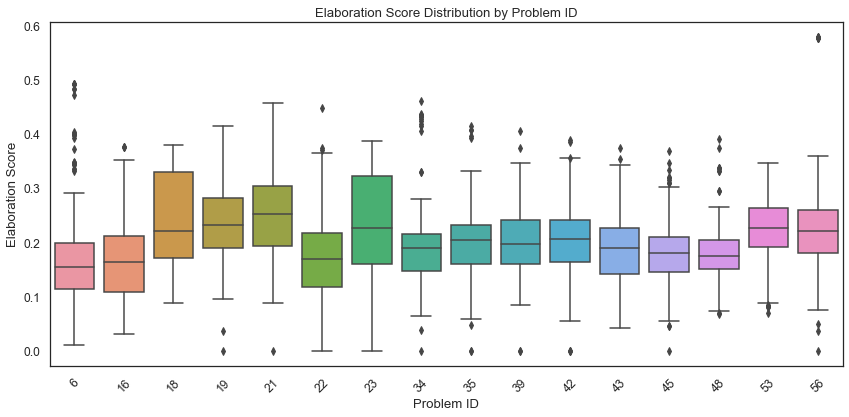

In [19]:
plt.figure(figsize=(12, 6))
sns.boxplot(x="problem_id", y="elaboration_score", data=df)
plt.xticks(rotation=45)
plt.title("Elaboration Score Distribution by Problem ID")
plt.xlabel("Problem ID")
plt.ylabel("Elaboration Score")
plt.tight_layout()
plt.show()

In [20]:
# Create a list of elaboration score groups for each problem
elab_groups = [group["elaboration_score"].values for _, group in df.groupby("problem_id")]

# Perform Kruskal-Wallis H-test
kruskal_stat, p_value = kruskal(*elab_groups)

print(f"Kruskal-Wallis H = {kruskal_stat:.4f}, p = {p_value:.4f}")

Kruskal-Wallis H = 841.8651, p = 0.0000


In [21]:
import scikit_posthocs as sp

# Run Dunn's test
dunn_result = sp.posthoc_dunn(df, val_col='elaboration_score', group_col='problem_id', p_adjust='bonferroni')

# Show a subset 
dunn_result.round(3).iloc[:5, :5]

,6,16,18,19,21
6,1.0,1.0,0.0,0.0,0.0
16,1.0,1.0,0.0,0.0,0.0
18,0.0,0.0,1.0,1.0,1.0
19,0.0,0.0,1.0,1.0,1.0
21,0.0,0.0,1.0,1.0,1.0


In [22]:
concept_map = {
    6: "Backtracking",
    16: "String Comparison",
    18: "MST",
    19: "Graph Traversal",
    21: "Graph Traversal",
    22: "Graph Filtering / Constraint Satisfaction",
    23: "Shortest Path",
    34: "Sorting",
    35: "Divide & Conquer",
    39: "Two Pointers",
    42: "Greedy",
    43: "Greedy",
    45: "Dynamic Programming",
    48: "Graph Traversal",
    53: "Graph Traversal",
    56: "MST"
}

# Map the problem_id column to a new concept column
df["problem_concept"] = df["problem_id"].map(concept_map)

In [23]:
concept_grouped = df.groupby("problem_concept")["elaboration_score"]
concept_stats = concept_grouped.agg(["mean", "std", "count"]).sort_values("mean", ascending=False)
print(concept_stats)

                                               mean       std  count
problem_concept                                                     
MST                                        0.234779  0.084665    509
Graph Traversal                            0.231889  0.069698   1756
Shortest Path                              0.230263  0.086783    365
Two Pointers                               0.200168  0.057292    600
Divide & Conquer                           0.196830  0.058139    391
Greedy                                     0.193393  0.061821    711
Sorting                                    0.184361  0.065435    447
Dynamic Programming                        0.177044  0.058153    369
Graph Filtering / Constraint Satisfaction  0.176481  0.082318    346
Backtracking                               0.166775  0.083328    410
String Comparison                          0.165654  0.083100    228


In [24]:
# Create a list of elaboration scores per concept
concept_scores = [group["elaboration_score"].values for name, group in df.groupby("problem_concept")]

# Kruskal-Wallis test
kruskal_result = kruskal(*concept_scores)
print("Kruskal-Wallis by concept:", kruskal_result)

Kruskal-Wallis by concept: KruskalResult(statistic=690.7085862268589, pvalue=6.200533571074919e-142)


In [25]:
posthoc = sp.posthoc_dunn(df, val_col='elaboration_score', group_col='problem_concept', p_adjust='bonferroni')
print(posthoc)

                                           Backtracking  Divide & Conquer  \
Backtracking                               1.000000e+00      6.432274e-12   
Divide & Conquer                           6.432274e-12      1.000000e+00   
Dynamic Programming                        5.036210e-01      1.824427e-04   
Graph Filtering / Constraint Satisfaction  1.000000e+00      9.841959e-05   
Graph Traversal                            1.445041e-65      1.371306e-12   
Greedy                                     5.332409e-12      1.000000e+00   
MST                                        1.258416e-41      3.123530e-07   
Shortest Path                              2.233447e-30      4.561911e-04   
Sorting                                    3.260833e-03      1.689833e-02   
String Comparison                          1.000000e+00      3.199511e-06   
Two Pointers                               4.945218e-15      1.000000e+00   

                                           Dynamic Programming  \
Backtrack

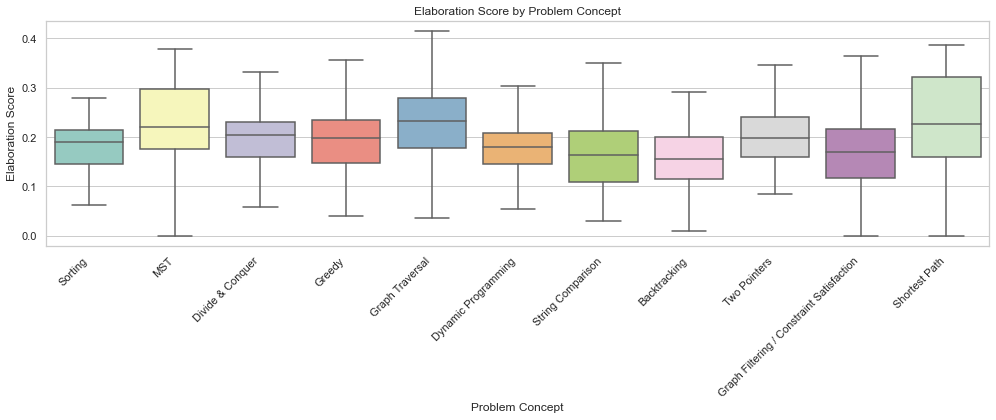

In [26]:
plt.figure(figsize=(14, 6))
sns.set(style="whitegrid")

sns.boxplot(
    data=df,
    x="problem_concept",
    y="elaboration_score",
    palette="Set3",
    showfliers=False
)


plt.xticks(rotation=45, ha='right')
plt.ylabel("Elaboration Score")
plt.xlabel("Problem Concept")
plt.title("Elaboration Score by Problem Concept")
plt.tight_layout()
plt.show()

In [27]:
feature_cols = [
    "elaboration_score",
    "comment_density",
    "num_methods",
    "avg_identifier_length",
    "doc_comment_density",
    "blank_line_ratio"
]

feature_stats = df[feature_cols].agg(['mean', 'std', 'min', 'quantile', 'max']).T
feature_stats['25%'] = df[feature_cols].quantile(0.25)
feature_stats['75%'] = df[feature_cols].quantile(0.75)

feature_stats = feature_stats.rename(columns={
    'mean': 'Mean',
    'std': 'Std. Dev.',
    'min': 'Min',
    'max': 'Max',
    '25%': '25th Pctl',
    '75%': '75th Pctl'
})

feature_stats = feature_stats[['Mean', 'Std. Dev.', 'Min', '25th Pctl', '75th Pctl', 'Max']]
feature_stats.round(3)

,Mean,Std. Dev.,Min,25th Pctl,75th Pctl,Max
elaboration_score,0.206,0.075,0.0,0.153,0.248,0.578
comment_density,0.036,0.058,0.0,0.000,0.051,0.401
num_methods,3.958,4.237,0.0,2.000,4.000,30.000
avg_identifier_length,3.612,1.184,0.0,2.873,4.279,10.857
doc_comment_density,0.023,0.226,0.0,0.000,0.000,6.000
blank_line_ratio,0.177,0.092,0.0,0.109,0.232,1.000


In [28]:
label_counts = df['label'].value_counts().sort_index()
label_percentages = 100 * label_counts / len(df)

label_summary = pd.DataFrame({
    'Count': label_counts,
    'Percent': label_percentages.round(1).astype(str) + '%'
})
print(label_summary)

               Count Percent
Accepted        2264   36.9%
Runtime Error   1886   30.8%
Wrong Answer    1982   32.3%
